In [3]:
import matplotlib.pyplot as plt 
from dataloader import InsectDatamodule
import numpy as np
import pandas as pd
import torchaudio
import torch
import IPython.display as ipd

In [5]:
datamodule = InsectDatamodule(csv_paths=['../data/Cicadidae.csv', '../data/Orthoptera.csv'], batch_size=10)
train_dataloader = datamodule.train_dataloader()

metadata = train_dataloader.dataset.get_metadata()

# Plotting the Visualization of the Transformation

In [6]:
def normalize(tensor):
    return (tensor - tensor.min()) / (tensor.max() - tensor.min())

def plot_transformation(path: str,
            index: int,
            n_fft: int, 
            top_db: int | None, 
            n_mels: int, 
            pad_length: int = 0, 
            show_audiosample: bool = False, 
            show_waveform: bool = False
            ):

    # loading the sample
    waveform, samplerate = train_dataloader.dataset.load_sample(path)

    # displaying the audio sample if true
    if show_audiosample:
        ipd.display(ipd.Audio(waveform.numpy()[0], rate=samplerate))


    # zero padding the waveform if needed
    if pad_length > 0:

        pad_samples = int(pad_length * samplerate)
        waveform = torch.nn.functional.pad(waveform, pad=(pad_samples, 0, 0, 0))


    # Displaying Waveform if true
    if show_waveform:

        time = np.arange(0, len(waveform[0])) / samplerate

        plt.plot(time, waveform[0, :])
        plt.title('Waveform')
        plt.xlabel('Time (s)')
        plt.show()

    # creating the mel spectrogram
    mel = torchaudio.transforms.MelSpectrogram(n_fft=n_fft, 
                                            hop_length=int(n_fft/2), 
                                            win_length=n_fft, 
                                            n_mels=n_mels
                                            )(waveform)

    # transforming the mel spectrogram with amplitude to db
    mel_db = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(mel)

    # normalizing the transformed mel spectrogram
    mel_db_norm = normalize(mel_db)

    # creating the spectrogram
    spec = torchaudio.transforms.Spectrogram(n_fft=n_fft, 
                                            hop_length=int(n_fft/2), 
                                            win_length=n_fft
                                            )(waveform)

    # transforming the spectrogram with amplitude to db
    spec_db = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)

    # normalizing the transformed spectrogram
    spec_db_norm = normalize(spec_db)

    #setting up the plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # plotting subplots
    ax[0].imshow(spec_db_norm.numpy().squeeze(), origin='lower', aspect='auto')
    ax[0].set_title('Spectrogram')
    fig.colorbar(ax[0].imshow(spec_db_norm.numpy().squeeze(), origin='lower', aspect='auto'), ax=ax[0])

    ax[1].imshow(mel_db_norm.numpy().squeeze(), origin='lower', aspect='auto')
    ax[1].set_title('Mel spectrogram')
    fig.colorbar(ax[1].imshow(mel_db_norm.numpy().squeeze(), origin='lower', aspect='auto'), ax=ax[1])

    # creating a legend:
    text = f'sample_index: {index}, n_fft: {n_fft}, n_mels: {n_mels}, top_db: {top_db}'

    # displaying the plot
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # adjust the bottom margin
    # plt.text(0.02, 0.1, text, ha='left', va='top', transform=fig.transFigure)
    
    return fig

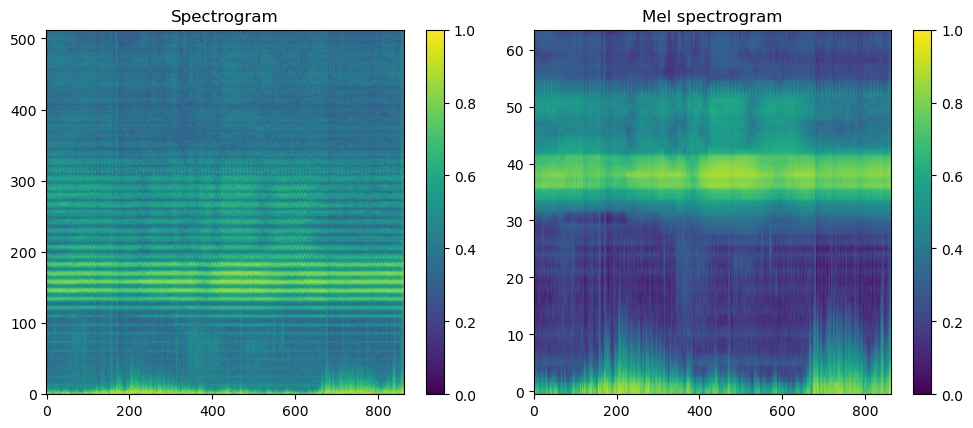

In [7]:
# figure_path = "../LaTeX/figures/"                                    
figure_path = None

# setting up the parameters
index=26
n_fft = 1024
n_mels = 64
top_db = None
pad_length = 0
show_audiosample = False
show_waveform = False

path = metadata['path'][index]

fig = plot_transformation(path=path,
        index=index,
        n_fft=n_fft, 
        top_db=top_db, 
        n_mels=n_mels, 
        pad_length=pad_length, 
        show_audiosample=show_audiosample, 
        show_waveform=show_waveform)

if figure_path is not None:
        fig.savefig(f'{figure_path}compare_spectrogram.pdf')
        plt.close(fig)



# Visualizing the Hyperparameter Tuning of the Model

In [25]:
# table_path = None
table_path = "../LaTeX/tables/"

eval_csv_path = "../logs/main_run/evaluation/eval_summary.csv"

# Loading the evaluation data
eval_data = pd.read_csv(eval_csv_path)
eval_data_selected = eval_data[['n_mels', 'n_res_blocks', 'learning_rate', 'kernel_size', 'accuracy', 'trained_epochs']]
eval_data_selected.loc[:, 'n_mels'] = eval_data_selected['n_mels'].fillna(-1).astype(int)
eval_data_selected_arranged = eval_data_selected.sort_values(by='accuracy', ascending=False)

# Formatting the DataFrame
eval_data_selected_arranged['n_mels'] = eval_data_selected_arranged['n_mels'].apply(lambda x: f"{x:.0f}")
eval_data_selected_arranged['learning_rate'] = eval_data_selected_arranged['learning_rate'].apply(lambda x: f"{x:.3g}")
eval_data_selected_arranged['accuracy'] = eval_data_selected_arranged['accuracy'].apply(lambda x: f"{x:.3f}")

# Convert DataFrame to LaTeX table
latex_table = eval_data_selected_arranged.to_latex(
    index=False, 
    column_format="rrrrrr"
)

# Manually replace the header row to make it bold
latex_table = latex_table.replace("n_mels & n_res_blocks & learning_rate & kernel_size & accuracy & trained_epochs \\\\",
                                  "\\textbf{n\\_mels} & \\textbf{n\\_res\\_blocks} & \\textbf{learning\\_rate} & \\textbf{kernel\\_size} & \\textbf{accuracy} & \\textbf{trained\\_epochs} \\\\")


# Saving the table
if table_path is None:
    print(latex_table)
else:
    with open(f'{table_path}hyperparameters_results.tex', 'w') as f:
        f.write(latex_table)